In [10]:
import numpy as np
import pandas as pd 
import fbprophet 
import plotly
import statsmodels
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
import altair as alt
import scipy
from scipy import signal
import spectrum 
from spectrum import WelchPeriodogram
from spectrum import Periodogram

In [2]:
flu_data = pd.read_csv('flu.csv', header = 2, sep = ',')

In [3]:
flu_data.head(n=5)

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,United States of America,Region of the Americas of WHO,North America,2013,1,2012-12-31,2013-01-06,18219,18219,0.0,...,0.0,1653,5377,0,0,1097,1097,6474,NaN,Widespread Outbreak
1,United States of America,Region of the Americas of WHO,North America,2013,2,2013-01-07,2013-01-13,20013,20013,0.0,...,0.0,1767,5752,0,0,1145,1145,6897,NaN,Widespread Outbreak
2,United States of America,Region of the Americas of WHO,North America,2013,3,2013-01-14,2013-01-20,19228,19228,0.0,...,0.0,1624,4858,0,0,1078,1078,5936,NaN,Widespread Outbreak
3,United States of America,Region of the Americas of WHO,North America,2013,4,2013-01-21,2013-01-27,17139,17139,0.0,...,0.0,1528,4039,0,0,1091,1091,5130,NaN,Widespread Outbreak
4,United States of America,Region of the Americas of WHO,North America,2013,5,2013-01-28,2013-02-03,14795,14795,0.0,...,0.0,951,2963,0,0,1076,1076,4039,NaN,Widespread Outbreak


In [4]:
alt.Chart(flu_data).mark_line().encode(
    x='EDATE:T',
    y='SPEC_RECEIVED_NB'
).transform_timeunit(
    month='month(date)'
)

alt.Chart(...)

In [5]:
SPEC_RECIEVD_NB_auto_cor = statsmodels.tsa.stattools.acf(flu_data.SPEC_RECEIVED_NB)

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [6]:
data = pd.DataFrame(list(enumerate(SPEC_RECIEVD_NB_auto_cor)), columns = ['Lag', 'AutoCor'])
alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
)

alt.Chart(...)

In [7]:
f, Pxx_den = scipy.signal.periodogram(flu_data.SPEC_RECEIVED_NB, fs = 1, scaling='density')

In [8]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

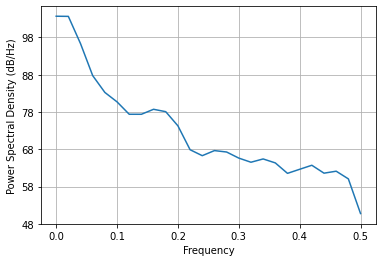

In [11]:
psd = WelchPeriodogram(flu_data.SPEC_RECEIVED_NB, 50)

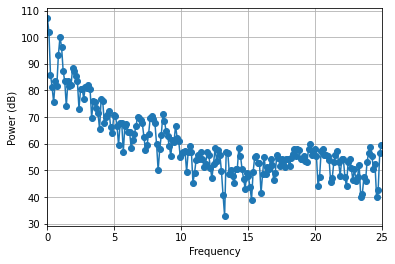

In [14]:
psd = Periodogram(flu_data.SPEC_RECEIVED_NB, 50)
psd.plot(marker='o')